In [1]:
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# customer_df = pd.read_csv('../Cleaned_Datasets/customer_SG_only.csv')
# orders_generated = pd.read_csv('../Cleaned_Datasets_orders_generated.csv')
products_cleaned = pd.read_csv('../Cleaned_Datasets/products_cleaned.csv')

**Preparing synthetic dataframe for marketing channels**

In [3]:
# Marketing Channel Data Frame

np.random.seed(42)
num_rows_marketing = 100000
marketing_channels = ['Email', 'Social Media', 'In-App', 'Website', 'SMS', 'KOL']

# We want to have more rows during sales period, as higher marketing spend is likely observed

# Define Shopee sales dates
mega_sales_dates = pd.to_datetime(['2019-01-01', '2019-02-02', '2019-03-03', '2019-04-04', '2019-05-05',
                                    '2019-06-06', '2019-07-07', '2019-08-08', '2019-09-09', '2019-10-10',
                                    '2019-11-11', '2019-12-12'])

# Christmas, new year, cyber monday, black friday sales dates etc
seasonal_sales_dates = pd.to_datetime(['2019-01-01', '2019-02-05', '2019-04-19', '2019-05-01', '2019-06-05',
                                       '2019-06-07', '2019-08-09', '2019-08-11', '2019-10-06', '2019-10-27', '2019-11-29', '2019-12-02',
                                       '2019-12-25', '2019-12-31'])

high_sales = pd.to_datetime(['2019-11-11', '2019-12-12', '2019-11-29'])
medium_sales = pd.to_datetime(['2019-06-06', '2019-09-09'])

# Build up marketing starting 7 days before sales, with increasing priority as the sale day approaches
days_before_sales = []
for sale_date in high_sales:
    days_before_sales.extend([sale_date - pd.DateOffset(days=i) for i in range(1, 8)])
# days_before_sales = pd.DatetimeIndex(days_before_sales)

mid_month_days = pd.to_datetime(['2019-' + str(month).zfill(2) + '-15' for month in range(1, 13)] +
                                ['2019-' + str(month).zfill(2) + '-25' for month in range(1, 13)])


dates = pd.date_range(start='2019-01-01', end='2019-12-31', freq='D').to_list()

# Base probabilities (low for regular dates)
base_prob = 1 / len(dates)
probabilities = np.full(len(dates), base_prob)

# Adjust probabilities for sale days and periods
for i, date in enumerate(dates):
    if date in high_sales:
        # Higher priority for sales dates but slightly lower than pre-sale days
        probabilities[i] = 0.04
    elif date in days_before_sales:
        # Pre-sale marketing build-up for high-priority sales (1-7 days before)
        days_diff = (high_sales - date).days.min()
        if days_diff == 1:
            probabilities[i] = 0.06
        elif days_diff in [2, 3]:
            probabilities[i] = 0.04
        elif days_diff in [4, 5]:
            probabilities[i] = 0.03
        elif days_diff in [6, 7]:
            probabilities[i] = 0.015
    elif date in mid_month_days:
        probabilities[i] = 0.015
    elif date in seasonal_sales_dates:
        probabilities[i] = 0.05
    else:
        probabilities[i] = base_prob

# Normalize probabilities
probabilities /= probabilities.sum()
marketing_dates = np.random.choice(dates, size=num_rows_marketing, p=probabilities)

# Given Shopee spent an estimated US$500 million on marketing spend in SEA
total_shopee_spend = 500000000
sg_share = 0.04
sg_shopee_spend = total_shopee_spend * sg_share

# Simulate Shopee's marketing channel proportions
channel_proportions = {
    'Email': 0.12,
    'Social Media': 0.22,
    'In-App': 0.24,
    'KOL': 0.20,
    'Website': 0.17,
    'SMS': 0.05,
}

# We calculate total expenditure per channel based on proportions
total_expenditures = {channel: sg_shopee_spend * proportion for channel, proportion in channel_proportions.items()}

# Simulate for pre-sale days - higher for social media and KOL
pre_sale_channel_weights = {
    'Email': 0.08,
    'Social Media': 0.35,
    'In-App': 0.15,
    'Website': 0.12,
    'SMS': 0.05,
    'KOL': 0.25
}

# Simulate for sale days - higher for in-app
sale_day_channel_weights = {
    'Email': 0.07,
    'Social Media': 0.20,
    'In-App': 0.35,
    'Website': 0.15,
    'SMS': 0.05,
    'KOL': 0.18
}

channels = []
for date in marketing_dates:
    if date in high_sales:
        channel_weights = list(sale_day_channel_weights.values())
        chosen_channel = np.random.choice(marketing_channels, p=channel_weights)
    elif date in days_before_sales:
        channel_weights = list(pre_sale_channel_weights.values())
        chosen_channel = np.random.choice(marketing_channels, p=channel_weights)
    else:
        channel_weights = list(channel_proportions.values())
        chosen_channel = np.random.choice(marketing_channels, p=channel_weights)
    channels.append(chosen_channel)

channels

marketing_df = pd.DataFrame({'channel_name': channels})

# We want to calculate the total expenditure per channel
channel_counts = marketing_df['channel_name'].value_counts().to_dict()

# We want to spread out the expenditure per channel and add in some random variation for realism
def spread_expenditure(channel_name):
    if channel_name in channel_counts:
        current_expenditure = total_expenditures[channel_name] / channel_counts[channel_name]
        random_variation = np.random.uniform(-0.2, 0.2)  # Variation between -20% and +20%
        return round(current_expenditure * (1 + random_variation), 2)
    return 0

marketing_df['channel_expenditure'] = marketing_df['channel_name'].apply(spread_expenditure)

visitor_multipliers = {
    'Email': np.random.uniform(0.2, 1.2) * 0.75,
    'SMS': np.random.uniform(0.3, 1.1) * 0.75,
    'KOL': np.random.uniform(4.5, 18) * 0.75,
    'In-App': np.random.uniform(2.25, 11.25) * 0.75,
    'Social Media': np.random.uniform(11.25, 22.5) * 0.75,
    'Website': np.random.uniform(2.25, 6.75) * 0.75
}

visitors = [
    np.round(marketing_df['channel_expenditure'][i] * visitor_multipliers[channels[i]], 0)
    for i in range(num_rows_marketing)
]

conversion_rates = {
    'Email': np.random.uniform(0.01, 0.023),
    'SMS': np.random.uniform(0.01, 0.026),
    'KOL': np.random.uniform(0.015, 0.03),
    'In-App': np.random.uniform(0.015, 0.03),
    'Social Media': np.random.uniform(0.01, 0.02),
    'Website': np.random.uniform(0.01, 0.025)
}

conversion_rate_list = np.array([
    conversion_rates[channels[i]] * np.random.uniform(0.9, 1.1)
    for i in range(num_rows_marketing)
])
print(conversion_rate_list)

# Calculate sales generated based on visitors and conversion rates
sales_generated = np.round(visitors * conversion_rate_list, 0)
sales_generated = np.where(sales_generated == 0, 1, sales_generated)
# conversion_rate = (sales_generated / visitors) * 100

# Average Order Value - overall for Shopee is around $15-$25
aov_list = [
    np.random.uniform(8, 16) if channel == 'Email' else
    np.random.uniform(6, 10) if channel == 'SMS' else
    np.random.uniform(15, 30) if channel == 'KOL' else
    np.random.uniform(10, 22) if channel == 'In-App' else
    np.random.uniform(10, 16) if channel == 'Social Media' else
    np.random.uniform(8, 20)
    for channel in channels
]

# Calculate Total Revenue based on sales and AOV, but ensure that revenue is > expenditure for realism
total_revenue = []

for i in range(num_rows_marketing):
    expenditure = marketing_df['channel_expenditure'].iloc[i]
    revenue = sales_generated[i] * aov_list[i]
    if revenue <= expenditure:
        revenue = expenditure * np.random.uniform(1.1, 1.3)

    total_revenue.append(round(revenue, 2))

click_through_rate = [
    np.random.uniform(0.1, 0.5) if channel == 'Email' else
    np.random.uniform(0.05, 0.2) if channel == 'SMS' else
    np.random.uniform(1, 3) if channel == 'KOL' else
    np.random.uniform(0.5, 1.5) if channel == 'In-App' else
    np.random.uniform(1, 5) if channel == 'Social Media' else
    np.random.uniform(0.5, 1)
    for channel in channels
]

bounce_rate = [
    np.random.uniform(38, 58) if channel == 'Email' else
    np.random.uniform(43, 63) if channel == 'SMS' else
    np.random.uniform(18, 37) if channel == 'KOL' else
    np.random.uniform(13, 32) if channel == 'In-App' else
    np.random.uniform(18, 37) if channel == 'Social Media' else
    np.random.uniform(23, 42)
    for channel in channels
]

customer_retention_rate = [
    np.random.uniform(0.1, 0.2) if channel == 'Email' else
    np.random.uniform(0.05, 0.15) if channel == 'SMS' else
    np.random.uniform(0.4, 0.6) if channel == 'KOL' else
    np.random.uniform(0.4, 0.6) if channel == 'In-App' else
    np.random.uniform(0.3, 0.5) if channel == 'Social Media' else
    np.random.uniform(0.15, 0.35)
    for channel in channels
]

[0.01940891 0.02119674 0.01582078 ... 0.01816034 0.02038534 0.01532121]


In [4]:
# Now we join the above columns to create our synthetic dataframe
marketing_df = pd.DataFrame({
    'date': marketing_dates,
    'channel_name': channels,
    'channel_expenditure': marketing_df['channel_expenditure'],
    'channel_visitors': visitors,
    'channel_sales': sales_generated,
    'conversion_rate': conversion_rate_list,
    'average_order_value': aov_list,
    'total_revenue': total_revenue,
    'click_through_rate': click_through_rate,
    'bounce_rate': bounce_rate,
    'customer_retention_rate': customer_retention_rate
})

marketing_df['day'] = marketing_df['date'].dt.day_name()
marketing_df.to_csv('synthetic_marketing_data.csv', index=False)

**Preparing synthetic dataframe for promotional campaigns**

In [5]:
np.random.seed(42)
num_rows = 100000

# Campaign Type Dataset
# Generate campaign types based on Shopee's promotional campaigns
campaign_ids = [np.random.randint(1000000, 9999999) for _ in range(num_rows)]
campaign_types = ['Flash Sale', 'Seasonal Sales', 'Bundle promotions', 'Mega Sales', 'Livestream Exclusive', 'Next Day Delivery']
campaign_costs = np.random.randint(1000, 10000, size=num_rows)

# Generate a common set of unique session_ids to be used by both datasets
unique_session_ids = np.random.choice(range(1, 999999), size=num_rows, replace=False)
session_ids = np.random.choice(unique_session_ids, size=num_rows, replace=True)

# Increase unique customer_id diversity
unique_customer_ids = np.random.choice(range(100000, 200000), size=int(num_rows * 0.8), replace=False)
repeated_customer_ids = np.random.choice(unique_customer_ids, size=int(num_rows * 0.2), replace=True)
customer_ids = np.concatenate((unique_customer_ids, repeated_customer_ids))
np.random.shuffle(customer_ids)

# Generate gender & age column for the customer
gender = np.random.choice(['Male', 'Female'], size=num_rows)
is_click = np.random.choice([0, 1], size=num_rows)
years = ['0-17 years', '18-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65 years and older']
age_group = np.random.choice(years, size=num_rows)


mega_sales_dates = pd.to_datetime(['2019-01-01', '2019-02-02', '2019-03-03', '2019-04-04', '2019-05-05',
                                   '2019-06-06', '2019-07-07', '2019-08-08', '2019-09-09', '2019-10-10',
                                   '2019-11-11', '2019-12-12'])

seasonal_sales_dates = pd.to_datetime(['2019-01-01', '2019-02-05', '2019-04-19', '2019-05-01', '2019-06-05',
                                       '2019-06-07', '2019-08-09', '2019-08-11', '2019-10-06', '2019-10-27', '2019-11-29', '2019-12-02',
                                       '2019-12-25', '2019-12-31'])

# Initialize lists for start and end dates
start_dates = []
end_dates = []
campaign_type_choices = []

for _ in range(num_rows):
    campaign_type = np.random.choice(campaign_types, p=[0.1, 0.1, 0.1, 0.4, 0.15, 0.15])  # Higher probability for Mega Sales
    campaign_type_choices.append(campaign_type)

    if campaign_type == 'Mega Sales':
        if np.random.rand() < 0.5:
            date = pd.Timestamp('2019-11-11')
        else:
            date = np.random.choice(mega_sales_dates)
        start_dates.append(date - pd.Timedelta(days=1))
        end_dates.append(date + pd.Timedelta(days=1))
    elif campaign_type == 'Seasonal Sales':
        index = np.random.randint(len(seasonal_sales_dates))
        start_dates.append(seasonal_sales_dates[index] - pd.Timedelta(days=1))
        end_dates.append(seasonal_sales_dates[index] + pd.Timedelta(days=1))
    else:
        random_start = pd.Timestamp(np.random.choice(pd.date_range('2019-01-01', '2019-12-31', freq='D')))
        start_dates.append(random_start)
        end_dates.append(random_start + pd.Timedelta(days=3))  # 3-day campaign

# Marketing channel, target audience, promotional type, and discount columns
marketing_channels = ['In-App', 'Social Media', 'KOL', 'Email', 'Website', 'SMS']
marketing_channel_prob = [0.35, 0.25, 0.15, 0.1, 0.1, 0.05]  # Higher probabilities for In-App, Social Media, and KOL


target_audience_probs = {
    'Mega Sales': [0.65, 0.35],  # New customers = 60-70%, Returning customers = 30-40%
    'Flash Sale': [0.45, 0.55],  # New customers = 40-50%, Returning customers = 50-60%
    'Bundle promotions': [0.35, 0.65],  # New customers = 30-40%, Returning customers = 60-70%
    'Livestream Exclusive': [0.35, 0.65],  # New customers = 30-40%, Returning customers = 60-70%
    'Next Day Delivery': [0.35, 0.65],  # New customers = 30-40%, Returning customers = 60-70%
    'Seasonal Sales': [0.25, 0.75]  # New customers = 20-30%, Returning customers = 70-80%
}

# Generate campaign types based on the defined probabilities
campaign_type_probs = [0.1, 0.1, 0.1, 0.4, 0.15, 0.15]  # Higher probability for Mega Sales
campaign_type_choices = np.random.choice(campaign_types, size=num_rows, p=campaign_type_probs)

# Generate target audience based on campaign type-specific probabilities
target_audience_choices = [
    np.random.choice(['New Customers', 'Returning Customers'], p=target_audience_probs[campaign_type])
    for campaign_type in campaign_type_choices
]

promotional_discount_types = ['Percentage', 'Fixed Amount']
promotional_discount_values = np.random.randint(20, 60, size=num_rows)  # Higher discount range

# Create the campaign DataFrame
campaign_df = pd.DataFrame({
    'campaign_id': campaign_ids,
    'campaign_type': campaign_type_choices,
    'campaign_cost': campaign_costs,
    # 'session_id': session_ids,
    'session_id' :unique_session_ids,
    'start_date': start_dates,
    'end_date': end_dates,
    'marketing_channel': np.random.choice(marketing_channels, size=num_rows, p=marketing_channel_prob),
    'target_audience': target_audience_choices,
    'promotional_discount_type': np.random.choice(promotional_discount_types, size=num_rows),
    'promotional_discount_value': promotional_discount_values,
    'gender': gender,
    'age_group': age_group,
    'is_click': is_click,
    'customer_id': customer_ids
})

# Save the campaign DataFrame to CSV
campaign_df.to_csv('synthetic_campaign_data.csv', index=False)

**Preparing synthetic order & sales dataframe**

In [6]:
np.random.seed(42)
num_rows = 100000

# Shopee Sales Dataset
target_categories = ['Health & Beauty', 'Women Clothes', 'Mobile & Accessories']
category_sales_prob = products_cleaned['main_category'].value_counts(normalize=True)
category_sales_prob.update(category_sales_prob[target_categories] * 2)
category_sales_prob = category_sales_prob / category_sales_prob.sum()
product_category_prob = products_cleaned['main_category'].map(category_sales_prob)
product_category_prob = product_category_prob / product_category_prob.sum()

order_id = [np.random.randint(0, 999999) for _ in range(num_rows)]
order_session_ids = np.random.choice(unique_session_ids, size=num_rows, replace=True)

# Generate diverse customer purchase behavior
duplicated_product_ids = np.random.choice(products_cleaned['product_id'], size=num_rows, replace=True, p=product_category_prob)
duplicated_customer_ids = np.random.choice(unique_customer_ids, size=num_rows, replace=True)

# Campaign flag with higher chance for Mega Sales campaign
is_campaign = np.random.choice([0, 1], size=num_rows, p=[0.3, 0.7])
product_df = products_cleaned[['product_id', 'main_category', 'price_actual']]

orders = pd.DataFrame({
    'order_id': order_id,
    'product_id': duplicated_product_ids,
    'customer_id': duplicated_customer_ids,
    'session_id': order_session_ids,
    'is_campaign': is_campaign
})

orders = orders.merge(product_df, on='product_id', how='left')
price_bins = [0, 20, 50, 100, 500, float('inf')]
orders['price_range'] = pd.cut(orders['price_actual'], bins=price_bins, labels=['Low', 'Mid-Low', 'Mid', 'Mid-High', 'High'])

campaign_sales_dates = np.union1d(mega_sales_dates, seasonal_sales_dates)
regular_dates = pd.date_range(start='2019-01-01', end='2019-12-31').difference(campaign_sales_dates).to_list()

# Increase order times for Mega Sales and especially 2019-11-11
if len(regular_dates) > 0 and len(mega_sales_dates) > 0:
    order_times = np.random.choice(
        regular_dates + list(mega_sales_dates),
        size=num_rows,
        p=[0.2 / len(regular_dates)] * len(regular_dates) + [0.8 / len(mega_sales_dates)] * len(mega_sales_dates)
    )
else:
    order_times = np.random.choice(list(mega_sales_dates), size=num_rows) if len(mega_sales_dates) > 0 else np.random.choice(regular_dates, size=num_rows)

# Assign generated order times to the 'order_time' column in the 'orders' DataFrame
orders['order_time'] = order_times

# Merge campaign types
orders = orders.merge(campaign_df[['session_id', 'campaign_type']], on='session_id', how='left')
orders['campaign_type'] = orders['campaign_type'].fillna('regular day')

# Set is_campaign to 1 for non-'regular day' campaign types, otherwise set to 0
orders['is_campaign'] = np.where(orders['campaign_type'] != 'regular day', 1, 0)

# Initialize discounts
orders['discount'] = 0

# Apply discount based on campaign types
orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['order_time'] == '2019-11-11') &
    (orders['campaign_type'] == 'Mega Sales'),
    'discount'
] = np.random.randint(20, 51, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['order_time'] == '2019-11-11') &
                                            (orders['campaign_type'] == 'Mega Sales')].shape[0]))

orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['campaign_type'] == 'Flash Sale'),
    'discount'
] = np.random.randint(15, 31, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['campaign_type'] == 'Flash Sale')].shape[0]))

orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['campaign_type'] == 'Seasonal Sales'),
    'discount'
] = np.random.randint(20, 41, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['campaign_type'] == 'Seasonal Sales')].shape[0]))

orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['campaign_type'] == 'Bundle promotions'),
    'discount'
] = np.random.randint(5, 16, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['campaign_type'] == 'Bundle promotions')].shape[0]))

orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['campaign_type'] == 'Livestream Exclusive'),
    'discount'
] = np.random.randint(25, 41, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['campaign_type'] == 'Livestream Exclusive')].shape[0]))

orders.loc[
    (orders['is_campaign'] == 1) &
    (orders['campaign_type'] == 'Next Day Delivery'),
    'discount'
] = np.random.randint(0, 11, size=(orders[(orders['is_campaign'] == 1) &
                                            (orders['campaign_type'] == 'Next Day Delivery')].shape[0]))

# Save the orders DataFrame to CSV
orders.to_csv('shopee_sales_df.csv', index=False)

**Data cleaning and preparation**

In [7]:
# Create an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Write DataFrames to SQL tables
orders.to_sql('sales', conn, index=False, if_exists='replace')
campaign_df.to_sql('campaigns', conn, index=False, if_exists='replace')

100000

In [8]:
# Sales for various campaign types on new customers and returning customers

query = """
WITH campaign_sales AS (
    SELECT
        s.order_id,
        s.customer_id,
        s.session_id,
        c.campaign_id,
        c.campaign_type,
        c.marketing_channel,
        c.target_audience,
        s.price_actual,
        s.discount,
        s.order_time
    FROM
        sales s
    JOIN
        campaigns c ON s.session_id = c.session_id
    WHERE
        s.is_campaign = 1
        AND s.order_time BETWEEN c.start_date AND c.end_date
),

campaign_summary AS (
    SELECT
        campaign_type,
        marketing_channel,
        target_audience,
        COUNT(DISTINCT order_id) AS total_orders,
        SUM(price_actual) AS total_sales,
        AVG(price_actual) AS average_order_value,
        AVG(discount) AS average_discount,
        COUNT(DISTINCT customer_id) AS unique_customers,
        COUNT(DISTINCT CASE WHEN target_audience = 'New Customers' THEN customer_id END) AS new_customers,
        COUNT(DISTINCT CASE WHEN target_audience = 'Returning Customers' THEN customer_id END) AS returning_customers
    FROM
        campaign_sales
    GROUP BY
        campaign_type, marketing_channel, target_audience
)

SELECT
    campaign_type,
    marketing_channel,
    target_audience,
    total_orders,
    total_sales,
    average_order_value,
    average_discount,
    unique_customers,
    new_customers,
    returning_customers

FROM
    campaign_summary
ORDER BY
    campaign_type, marketing_channel, target_audience;
"""

# Execute the query and display results
result_df = pd.read_sql_query(query, conn)
result_df.to_csv('shopee_sales_result.csv', index=False)

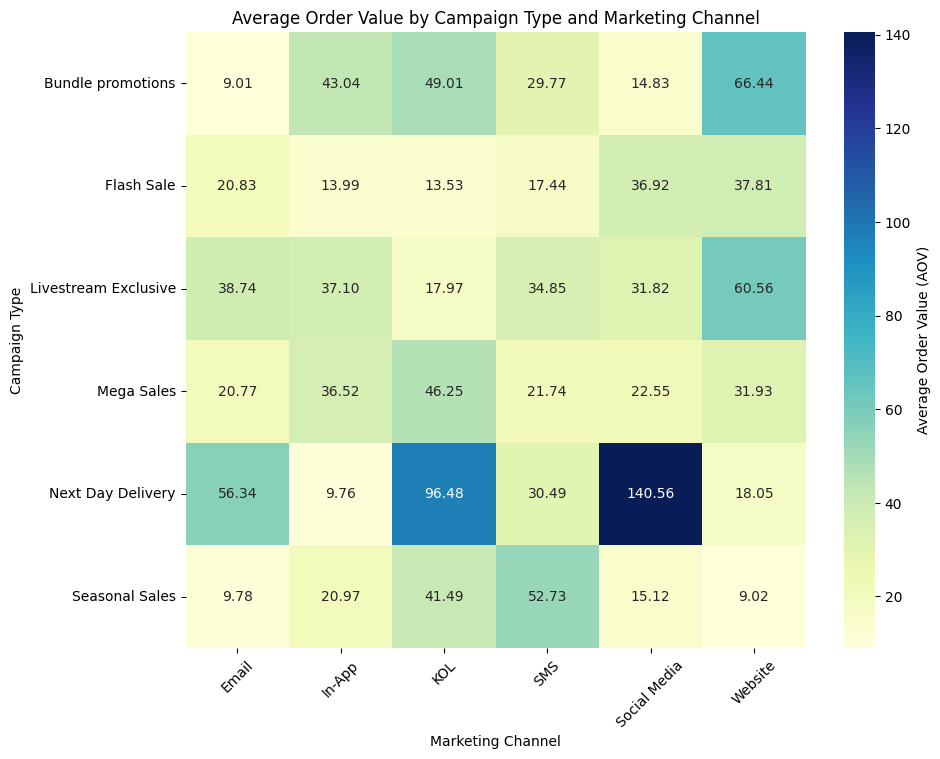

In [9]:
heatmap_data = result_df.pivot_table(values='average_order_value',
                                                  index='campaign_type',
                                                  columns='marketing_channel',
                                                  aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Order Value (AOV)'})
plt.title('Average Order Value by Campaign Type and Marketing Channel')
plt.xlabel('Marketing Channel')
plt.ylabel('Campaign Type')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [10]:
# Sales for various campaign types per month (Jan-Dec 2019)

query_2 = """
WITH monthly_sales AS (
    SELECT
        c.campaign_type,
        strftime('%Y-%m', s.order_time) AS month,
        SUM(s.price_actual) AS total_sales,
        COUNT(s.order_id) AS total_orders,
        AVG(s.discount) AS average_discount,
        COUNT(DISTINCT CASE WHEN c.target_audience = 'New Customers' THEN s.customer_id END) AS new_customers,
        COUNT(DISTINCT CASE WHEN c.target_audience = 'Returning Customers' THEN s.customer_id END) AS returning_customers
    FROM
        sales s
    JOIN
        campaigns c ON s.session_id = c.session_id
    WHERE
        s.is_campaign = 1
        AND strftime('%Y', s.order_time) = '2019'
    GROUP BY
        c.campaign_type, strftime('%Y-%m', s.order_time)
)

SELECT
    campaign_type,
    month,
    total_sales,
    total_orders,
    average_discount,
    new_customers,
    returning_customers
FROM
    monthly_sales
ORDER BY
    campaign_type, month;

"""

# Execute the query_2 and display results
result_df_2 = pd.read_sql_query(query_2, conn)
result_df_2.to_csv('shopee_sales_monthly_per_campaign_result.csv', index=False)

In [11]:
# Sales per month (Jan-Dec 2019)

query_3 = """
WITH monthly_sales AS (
    SELECT
        c.campaign_type,
        strftime('%Y-%m', s.order_time) AS month,
        SUM(s.price_actual) AS total_sales,
        COUNT(s.order_id) AS total_orders,
        AVG(s.discount) AS average_discount,
        COUNT(DISTINCT CASE WHEN c.target_audience = 'New Customers' THEN s.customer_id END) AS new_customers,
        COUNT(DISTINCT CASE WHEN c.target_audience = 'Returning Customers' THEN s.customer_id END) AS returning_customers
    FROM
        sales s
    JOIN
        campaigns c ON s.session_id = c.session_id
    WHERE
        s.is_campaign = 1
        AND strftime('%Y', s.order_time) = '2019'
    GROUP BY
        strftime('%Y-%m', s.order_time)
)

SELECT
    campaign_type,
    month,
    total_sales,
    total_orders,
    average_discount,
    new_customers,
    returning_customers
FROM
    monthly_sales
ORDER BY
    month;

"""

# Execute the query_2 and display results
result_df_3 = pd.read_sql_query(query_3, conn)
result_df_3.to_csv('shopee_sales_monthly_result.csv', index=False)